# PCA Graphs
This notebook will be used to try and check the usefulness of PCA analysis in our assessment data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import pathlib as Path
import html5lib
import json
import matplotlib.ticker as mtick
import plotly.express as px
import sklearn 
import warnings
warnings.filterwarnings("ignore")

In [2]:
#This finds files that were saved by the Module Scraper Code
def file_finder(school=None, level=None, givenList=None, filename=None, module=None):
    #Set the path to the overall directory with our input files
    dir_raw=Path.Path("ModuleInformation")
    
    #This locates the subdirectory where files by school, level or list can be found
    subdirectory=""
    #Set the subdirectory 
    if level != None:
        subdirectory+= "Level=%d" %(level)
    if school != None:
        subdirectory+= "_School="+school.replace(" ", "-")
    if filename != None:
        subdirectory = filename
    if module != None:
        subdirectory = ("IndividualModules/%s" %module)
        
    #If a subdirectory has indeed been set, change the path to reflect this
    if len(subdirectory) > 0:
        dir_raw =dir_raw / subdirectory
        

    #Read the files for the assessment and descriptors in, closing the file immediately after
    with open(dir_raw / "assessments.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        if module != None:
            assessments=pd.read_json(infile, orient="columns")
        else:
            assessments=pd.read_json(infile)
    with open(dir_raw / "descriptors.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        if module != None:
            descriptors=pd.read_json(infile, typ="series")
        else:
            descriptors=pd.read_json(infile)
    
    assessments["Level"]=assessments["Level"].apply(lambda x: pd.to_numeric(x.split('(')[0], errors='ignore'))
    #This is the dataset cleaning, so that they are ready for presentation
    assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')
    assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
    assessments["Assessment Type"]=assessments["Assessment Type"].astype("category")
    #assessments["Stage"]=assessments["Stage"].replace("M", 4)
    assessments["Student Credits"]=((assessments["Scaled % of Final Grade"]/100)*5)*assessments["Enrolled Students 22/23"]
    assessments["Assessment Credits"]=((assessments["Scaled % of Final Grade"]/100)*5)
    #Return the desired assessment and description information
    return assessments, descriptors

In [3]:
#Test the file finder function 
assessments, descriptors = file_finder()

assessments

Reading from ModuleInformation
Reading from ModuleInformation


,Description,Timing,Open Book Exam,Component Scale,Must Pass Component,% of Final Grade,Assessment Type,Module Code,Scaled % of Final Grade,Work Type,Level,Credits,School,Module Coordinator,Semester,Enrolled Students 22/23,Stage,Student Credits,Assessment Credits
0,Fieldwork: Fieldwork on campus related to camp...,Throughout the Trimester,None,Graded,No,30,Fieldwork,DSCY10060,30,In person,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,NaN,55.5,1.50
1,Presentation: In class presentation of group p...,Week 12,None,Graded,No,30,Presentation,DSCY10060,30,In person,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,NaN,55.5,1.50
2,Multiple Choice Questionnaire: Online Multiple...,Throughout the Trimester,None,Standard conversion grade scale 40%,No,40,Multiple Choice Questionnaire,DSCY10060,40,Blended,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,NaN,74.0,2.00
3,Examination: 2 HOUR Examination,2 hour End of Trimester Exam,No,Alternative linear conversion grade scale 40%,No,65,Examination,EEEN10010,65,In person,1,5.0,Electrical & Electronic Eng,Assoc Professor Simon Kelly,Autumn,298,NaN,968.5,3.25
4,"Lab Report: Two in-person labs will be run , w...",Varies over the Trimester,None,Alternative linear conversion grade scale 40%,No,10,Lab Report,EEEN10010,10,Blended,1,5.0,Electrical & Electronic Eng,Assoc Professor Simon Kelly,Autumn,298,NaN,149.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,Assignment: Final report and presentation,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,70,Assignment,MEEN50080,280,At home,5,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0,14.00
1271,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50080,40,At home,5,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0,2.00
1272,Assignment: Development of work plan,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,20,Assignment,MEEN50090,120,At home,5,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0,6.00
1273,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50090,60,At home,5,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0,3.00


In [4]:
work_type={"Assignment" :"At home", \
                "Attendance": "In person", \
                "Class Test" : "In person", \
                "Continuous Assessment": "At home", \
               "Essay": "At home", \
                "Examination": "In person", \
                "Fieldwork": "In person", \
                "Group Project": "Blended", \
                "Journal": "Blended",\
               "Lab Report": "Blended", \
                "Multiple Choice Questionnaire": "Blended", \
                "Oral Examination": "In person", \
               "Portfolio" : "Blended",  \
                "Practical Examination": "In person", \
                "Presentation" : "In person", \
                "Project": "At home", \
               "Seminar": "In person", \
               "Studio Examination" : "In person",\
               "Assessments worth <2%": "Unknown"}

In [5]:
assessments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1275 entries, 0 to 1274
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Description              1275 non-null   object  
 1   Timing                   1275 non-null   object  
 2   Open Book Exam           176 non-null    object  
 3   Component Scale          1275 non-null   object  
 4   Must Pass Component      1275 non-null   object  
 5   % of Final Grade         1275 non-null   int64   
 6   Assessment Type          1275 non-null   category
 7   Module Code              1275 non-null   object  
 8   Scaled % of Final Grade  1275 non-null   int64   
 9   Work Type                1275 non-null   object  
 10  Level                    1275 non-null   int64   
 11  Credits                  1275 non-null   float64 
 12  School                   1275 non-null   object  
 13  Module Coordinator       1275 non-null   object  
 14  Semester     

In [6]:
assessments.nunique()

Description                1072
Timing                       20
Open Book Exam                3
Component Scale               6
Must Pass Component           2
% of Final Grade             41
Assessment Type              18
Module Code                 513
Scaled % of Final Grade      70
Work Type                     3
Level                         5
Credits                       9
School                        6
Module Coordinator          151
Semester                      9
Enrolled Students 22/23     109
Stage                         0
Student Credits             408
Assessment Credits           70
dtype: int64

In [7]:
module_analysis=assessments.pivot_table("% of Final Grade", \
                               ["School", "Level", "Module Code", "Enrolled Students 22/23", "Credits"], \
                               "Assessment Type", observed=True, fill_value=0)
module_analysis.reset_index( inplace=True)

module_analysis

Assessment Type,School,Level,Module Code,Enrolled Students 22/23,Credits,Assignment,Attendance,Class Test,Continuous Assessment,Essay,...,Journal,Lab Report,Multiple Choice Questionnaire,Oral Examination,Portfolio,Practical Examination,Presentation,Project,Seminar,Studio Examination
0,"Architecture, Plan & Env Pol",1,ARCT10010,72,15.0,0.000000,0,0.0,0.0,0.0,...,0.0,0,0,0,100,0,0.0,0.0,0,0.0
1,"Architecture, Plan & Env Pol",1,ARCT10020,61,15.0,0.000000,0,0.0,0.0,0.0,...,0.0,0,0,0,100,0,0.0,0.0,0,0.0
2,"Architecture, Plan & Env Pol",1,ARCT10030,78,5.0,0.000000,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0.0,50.0,0,0.0
3,"Architecture, Plan & Env Pol",1,ARCT10040,61,5.0,0.000000,0,0.0,0.0,10.0,...,0.0,0,0,0,50,0,0.0,0.0,0,0.0
4,"Architecture, Plan & Env Pol",1,ARCT10070,80,5.0,10.000000,0,0.0,0.0,30.0,...,0.0,0,0,0,0,0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,Mechanical & Materials Eng,5,MEEN50020,0,5.0,0.000000,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0.0,100.0,0,0.0
509,Mechanical & Materials Eng,5,MEEN50060,0,15.0,0.000000,0,0.0,70.0,0.0,...,0.0,0,0,0,0,0,30.0,0.0,0,0.0
510,Mechanical & Materials Eng,5,MEEN50070,0,10.0,33.333333,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0.0,0.0,0,0.0
511,Mechanical & Materials Eng,5,MEEN50080,0,20.0,33.333333,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0.0,0.0,0,0.0


In [8]:
#Reset the index and make a new index of all the columns that should make a row unique
module_analysis.set_index("Module Code", inplace=True)
module_analysis

Assessment Type,School,Level,Enrolled Students 22/23,Credits,Assignment,Attendance,Class Test,Continuous Assessment,Essay,Examination,...,Journal,Lab Report,Multiple Choice Questionnaire,Oral Examination,Portfolio,Practical Examination,Presentation,Project,Seminar,Studio Examination
Module Code,,,,,,,,,,,,,,,,,,,,,
ARCT10010,"Architecture, Plan & Env Pol",1,72,15.0,0.000000,0,0.0,0.0,0.0,0,...,0.0,0,0,0,100,0,0.0,0.0,0,0.0
ARCT10020,"Architecture, Plan & Env Pol",1,61,15.0,0.000000,0,0.0,0.0,0.0,0,...,0.0,0,0,0,100,0,0.0,0.0,0,0.0
ARCT10030,"Architecture, Plan & Env Pol",1,78,5.0,0.000000,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0.0,50.0,0,0.0
ARCT10040,"Architecture, Plan & Env Pol",1,61,5.0,0.000000,0,0.0,0.0,10.0,40,...,0.0,0,0,0,50,0,0.0,0.0,0,0.0
ARCT10070,"Architecture, Plan & Env Pol",1,80,5.0,10.000000,0,0.0,0.0,30.0,40,...,0.0,0,0,0,0,0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MEEN50020,Mechanical & Materials Eng,5,0,5.0,0.000000,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0.0,100.0,0,0.0
MEEN50060,Mechanical & Materials Eng,5,0,15.0,0.000000,0,0.0,70.0,0.0,0,...,0.0,0,0,0,0,0,30.0,0.0,0,0.0
MEEN50070,Mechanical & Materials Eng,5,0,10.0,33.333333,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0.0,0.0,0,0.0


In [9]:
# Import label encoder
from sklearn import preprocessing
  
#Create the label encoder
label= preprocessing.LabelEncoder()
#Create a new value
module_analysis["School"]=label.fit_transform(module_analysis["School"])
module_analysis["Student Credits"]=module_analysis["Enrolled Students 22/23"]*module_analysis["Credits"]

work_type={"Assignment" :"At home", \
                "Attendance": "In person", \
                "Class Test" : "In person", \
                "Continuous Assessment": "At home", \
               "Essay": "At home", \
                "Examination": "In person", \
                "Fieldwork": "In person", \
                "Group Project": "Blended", \
                "Journal": "Blended",\
               "Lab Report": "Blended", \
                "Multiple Choice Questionnaire": "Blended", \
                "Oral Examination": "In person", \
               "Portfolio" : "Blended",  \
                "Practical Examination": "In person", \
                "Presentation" : "In person", \
                "Project": "At home", \
               "Seminar": "In person", \
               "Studio Examination" : "In person",\
               "Assessments worth <2%": "Unknown"}

module_analysis["In Person Percentage"]=module_analysis["Attendance"]+module_analysis["Class Test"]+\
module_analysis["Examination"]+module_analysis["Fieldwork"]+module_analysis["Oral Examination"]\
+module_analysis["Practical Examination"]+module_analysis["Presentation"]+module_analysis["Seminar"]+\
module_analysis["Studio Examination"]

module_analysis["At Home Percentage"]=module_analysis["Assignment"]+module_analysis["Continuous Assessment"]+\
module_analysis["Essay"]+module_analysis["Project"]

module_analysis["Blended Percentage"]=module_analysis["Group Project"]+module_analysis["Journal"]+\
module_analysis["Lab Report"]+module_analysis["Multiple Choice Questionnaire"]+module_analysis["Portfolio"]

module_analysis

Assessment Type,School,Level,Enrolled Students 22/23,Credits,Assignment,Attendance,Class Test,Continuous Assessment,Essay,Examination,...,Portfolio,Practical Examination,Presentation,Project,Seminar,Studio Examination,Student Credits,In Person Percentage,At Home Percentage,Blended Percentage
Module Code,,,,,,,,,,,,,,,,,,,,,
ARCT10010,0,1,72,15.0,0.000000,0,0.0,0.0,0.0,0,...,100,0,0.0,0.0,0,0.0,1080.0,0.0,0.000000,100.0
ARCT10020,0,1,61,15.0,0.000000,0,0.0,0.0,0.0,0,...,100,0,0.0,0.0,0,0.0,915.0,0.0,0.000000,100.0
ARCT10030,0,1,78,5.0,0.000000,0,0.0,0.0,0.0,0,...,0,0,0.0,50.0,0,0.0,390.0,0.0,50.000000,0.0
ARCT10040,0,1,61,5.0,0.000000,0,0.0,0.0,10.0,40,...,50,0,0.0,0.0,0,0.0,305.0,40.0,10.000000,50.0
ARCT10070,0,1,80,5.0,10.000000,0,0.0,0.0,30.0,40,...,0,0,0.0,0.0,0,0.0,400.0,40.0,40.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MEEN50020,5,5,0,5.0,0.000000,0,0.0,0.0,0.0,0,...,0,0,0.0,100.0,0,0.0,0.0,0.0,100.000000,0.0
MEEN50060,5,5,0,15.0,0.000000,0,0.0,70.0,0.0,0,...,0,0,30.0,0.0,0,0.0,0.0,30.0,70.000000,0.0
MEEN50070,5,5,0,10.0,33.333333,0,0.0,0.0,0.0,0,...,0,0,0.0,0.0,0,0.0,0.0,0.0,33.333333,0.0


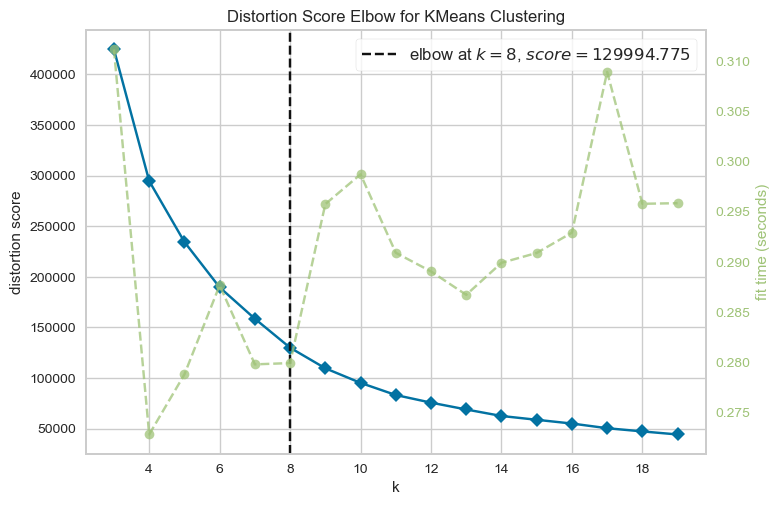

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model=KMeans(n_init=10)

visualizer = KElbowVisualizer(model, k=(3,20))

# Fit the data to the visualizer
visualizer.fit(module_analysis[["Blended Percentage", "At Home Percentage", "In Person Percentage"]])        

visualizer.show()        # Finalize and render the figure

In [12]:
model=KMeans(n_clusters=8,n_init=10, random_state=1024)

kmeans=model.fit(module_analysis[["Blended Percentage", "At Home Percentage", "In Person Percentage"]])

print(len(kmeans.labels_))

module_analysis["Cluster"]=kmeans.labels_

module_analysis

513


Assessment Type,School,Level,Enrolled Students 22/23,Credits,Assignment,Attendance,Class Test,Continuous Assessment,Essay,Examination,...,Practical Examination,Presentation,Project,Seminar,Studio Examination,Student Credits,In Person Percentage,At Home Percentage,Blended Percentage,Cluster
Module Code,,,,,,,,,,,,,,,,,,,,,
ARCT10010,0,1,72,15.0,0.000000,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0,0.0,1080.0,0.0,0.000000,100.0,6
ARCT10020,0,1,61,15.0,0.000000,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0,0.0,915.0,0.0,0.000000,100.0,6
ARCT10030,0,1,78,5.0,0.000000,0,0.0,0.0,0.0,0,...,0,0.0,50.0,0,0.0,390.0,0.0,50.000000,0.0,0
ARCT10040,0,1,61,5.0,0.000000,0,0.0,0.0,10.0,40,...,0,0.0,0.0,0,0.0,305.0,40.0,10.000000,50.0,4
ARCT10070,0,1,80,5.0,10.000000,0,0.0,0.0,30.0,40,...,0,0.0,0.0,0,0.0,400.0,40.0,40.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MEEN50020,5,5,0,5.0,0.000000,0,0.0,0.0,0.0,0,...,0,0.0,100.0,0,0.0,0.0,0.0,100.000000,0.0,3
MEEN50060,5,5,0,15.0,0.000000,0,0.0,70.0,0.0,0,...,0,30.0,0.0,0,0.0,0.0,30.0,70.000000,0.0,5
MEEN50070,5,5,0,10.0,33.333333,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0,0.0,0.0,0.0,33.333333,0.0,0


In [13]:
clusterCor=pd.DataFrame(model.fit_transform(module_analysis))

clusterCor

,0,1,2,3,4,5,6,7
0,1038.897527,99.925128,602.269333,918.425230,364.799430,1063.561491,443.653271,794.270947
1,875.457528,143.517529,444.175955,755.691053,224.032462,900.585038,594.103595,632.556080
2,356.090622,643.540621,127.444638,230.284607,361.193001,370.365847,1086.837718,117.128558
3,264.329662,725.206889,203.197874,155.129603,445.676457,303.733274,1171.083355,77.063886
4,357.012728,634.193607,100.580907,234.378451,347.607054,384.864746,1073.989131,113.271676
...,...,...,...,...,...,...,...,...
508,157.563065,1040.853571,517.415963,213.176274,761.308915,95.353915,1487.869501,326.940552
509,114.616965,1038.387888,509.317342,194.785932,756.649393,79.133349,1483.871460,311.398312
510,94.299463,1035.151037,504.375758,182.913841,753.281173,66.294785,1482.492775,307.967333
511,95.119308,1035.141981,504.474881,183.334409,753.313033,66.919431,1482.536138,308.193833


<Axes: xlabel='Assessment Type', ylabel='Assessment Type'>

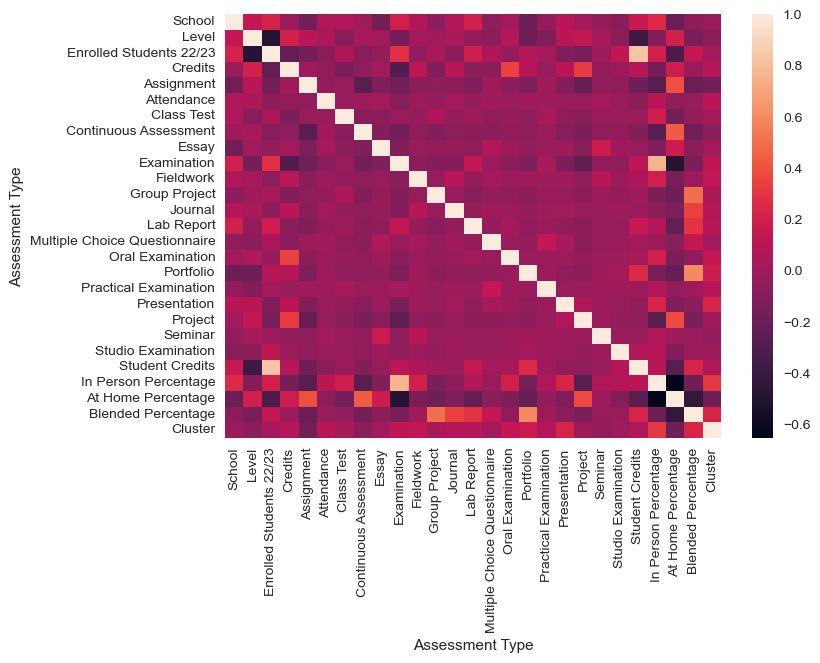

In [14]:
correlation=module_analysis.corr()

sns.heatmap(correlation)

In [15]:
cluster_basis=correlation["Cluster"].apply(lambda x: abs(x)).sort_values()

#cluster_basis.drop(labels=["Cluster"])

cluster_basis

Assessment Type
Studio Examination               0.005493
Project                          0.006191
School                           0.013330
Multiple Choice Questionnaire    0.014737
Enrolled Students 22/23          0.016637
Essay                            0.019748
Class Test                       0.025802
Seminar                          0.046443
Group Project                    0.050230
Student Credits                  0.060284
Continuous Assessment            0.064806
Level                            0.073633
Journal                          0.083306
Practical Examination            0.087536
Credits                          0.091108
Lab Report                       0.092880
Attendance                       0.104351
Examination                      0.128392
Fieldwork                        0.132303
Oral Examination                 0.144985
Assignment                       0.169829
Portfolio                        0.179117
At Home Percentage               0.182798
Blended Percentage

Text(0.5, 1.0, 'What are the Clusters Based on?')

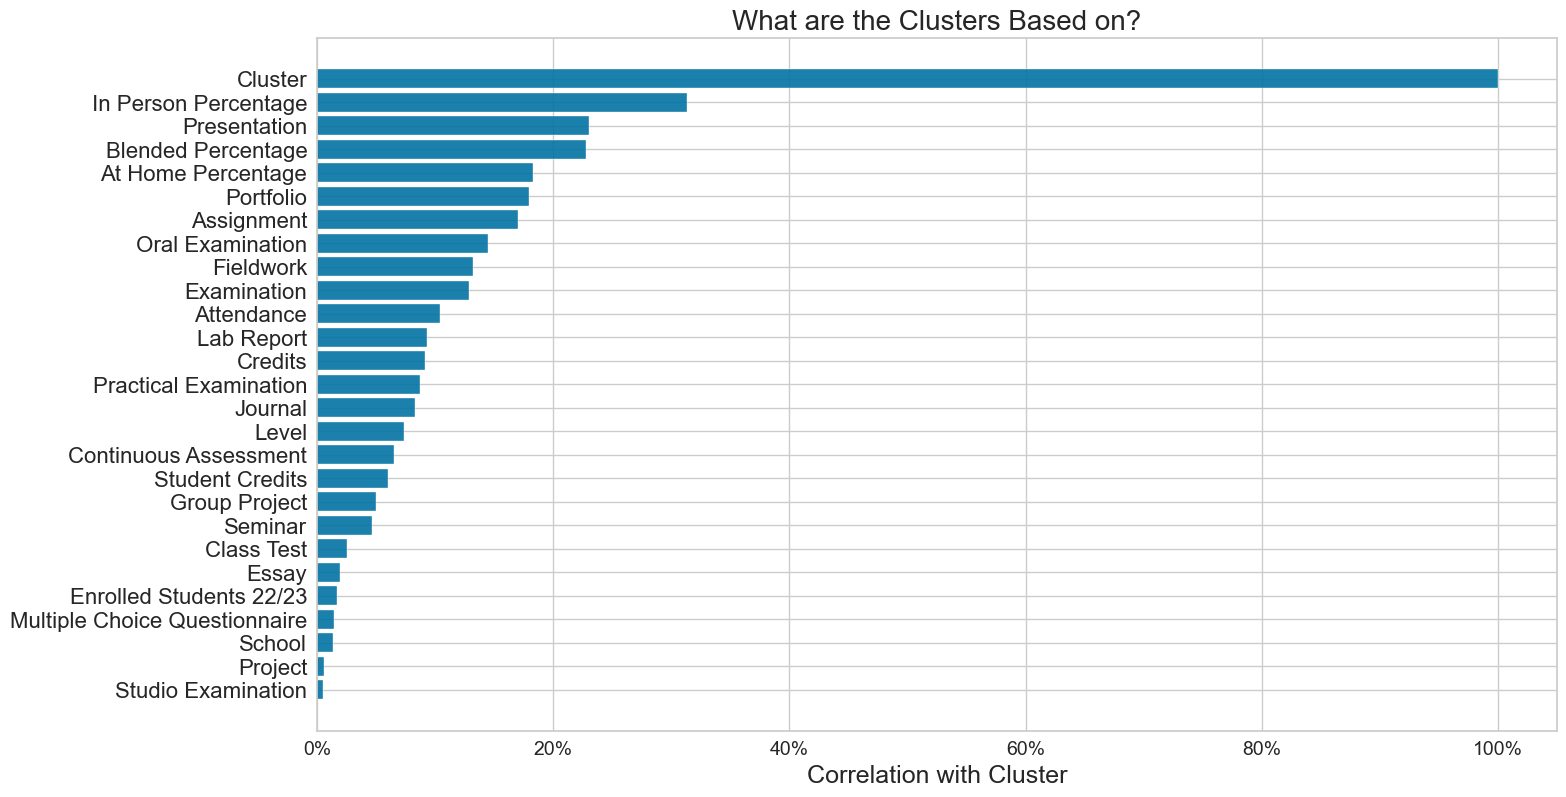

In [16]:
fig, ax=plt.subplots(figsize=(16, 9))

#Make the assessment type breakdown bar chart, with colour and hatching indicating the susceptibility
ax.barh(cluster_basis.index, cluster_basis.apply(lambda x: x*100), edgecolor="white",  alpha=0.9)

    #colors = {'fruit':'red', 'veggie':'green'}         
#Set the options for the axes
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=14)
    
fmt = '%d%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
#ax.legend(fontsize=20)
ax.set_xlabel("Correlation with Cluster",fontsize=18)
#Set the title for the bar chart for ease of understanding
ax.set_title("What are the Clusters Based on?", fontsize=20)



In [17]:
centroids=pd.DataFrame(kmeans.cluster_centers_)
module_analysis["Cluster"]=kmeans.labels_


centroids.columns=module_analysis.columns

for column in centroids.columns:
    if column != "Cluster":
        centroids[column]=centroids[column].apply(lambda x: "%.2f" %x)
    #else:
     #   centroids[column]=centroids[column].apply(lambda x: "%d" %x)

centroids["Cluster Size"]=module_analysis["Cluster"].value_counts()

centroids

Assessment Type,School,Level,Enrolled Students 22/23,Credits,Assignment,Attendance,Class Test,Continuous Assessment,Essay,Examination,...,Presentation,Project,Seminar,Studio Examination,Student Credits,In Person Percentage,At Home Percentage,Blended Percentage,Cluster,Cluster Size
0,2.33,3.66,10.32,7.24,9.87,2.59,4.26,5.00,1.26,34.82,...,6.65,1.00,0.47,1.27,53.12,57.89,17.13,18.32,3.988235,85
1,2.06,3.00,94.19,15.94,5.69,0.00,3.44,0.62,0.00,6.88,...,1.88,16.62,0.00,0.00,1027.81,18.44,22.94,50.75,4.750000,16
2,2.57,3.21,76.14,10.00,12.80,0.00,0.75,4.46,9.29,30.86,...,2.86,5.36,0.00,0.00,495.54,35.18,31.91,13.61,2.464286,28
3,1.96,3.38,30.23,7.30,22.46,0.32,4.01,8.69,5.97,22.44,...,2.14,6.99,1.21,0.00,174.35,31.00,44.11,13.14,2.806452,124
4,3.72,2.88,104.36,12.60,10.84,0.04,1.44,2.40,0.60,24.32,...,6.00,13.60,0.00,0.00,743.80,38.20,27.44,18.76,3.840000,25
5,1.99,3.94,5.02,10.84,31.68,1.28,0.62,23.20,3.18,0.29,...,2.89,22.43,0.00,0.00,31.57,5.19,80.48,5.35,2.854015,137
6,3.86,1.57,258.00,8.57,5.71,0.00,2.14,10.71,0.00,35.00,...,0.00,0.00,0.00,8.57,1457.86,50.00,16.43,24.29,2.857143,7
7,2.14,3.07,48.27,8.02,13.82,1.10,2.57,21.09,4.78,23.00,...,1.74,4.07,0.00,1.33,299.51,32.43,43.75,13.20,3.351648,91


In [18]:
clusters=module_analysis.pop("Cluster")

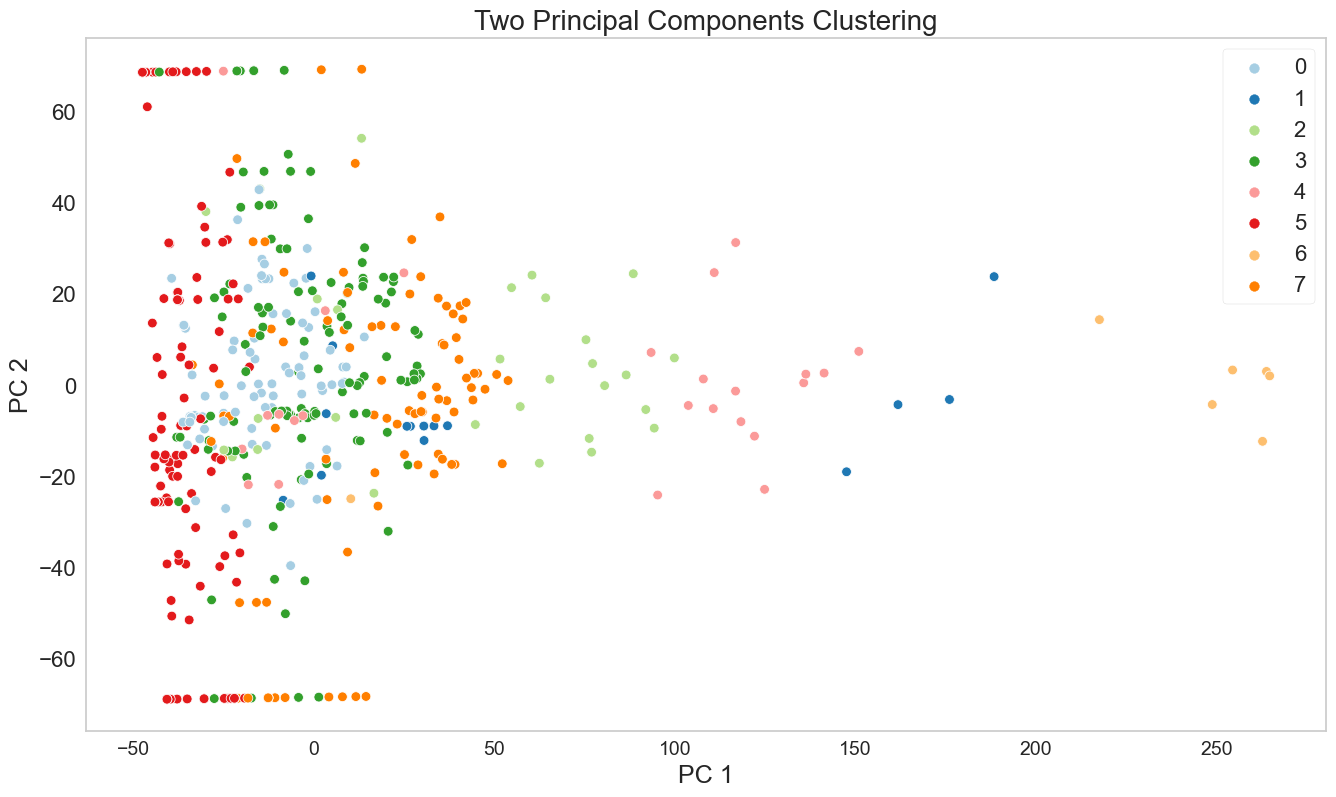

In [19]:
from sklearn.decomposition import PCA


fig, ax=plt.subplots(figsize=(16, 9))

#Reduce the dimensionality using pca
pca=PCA(n_components=2)

["Assignment", "Attendance", "Class Test", "Continuous Assessment", "Essay", "Examination", "Fieldwork",\
"Group Project", "Journal", "Lab Report", "Multiple Choice Questionnaire", "Oral Examination", "Portfolio",\
"Practical Examination", "Presentation", "Project", "Seminar", "Studio Examination"]

p_components=\
pd.DataFrame(pca.fit_transform(module_analysis[["Level", "Enrolled Students 22/23", "Assignment", "Attendance", "Class Test",\
                                                "Continuous Assessment", "Essay", "Examination", "Fieldwork",\
"Group Project", "Journal", "Lab Report", "Multiple Choice Questionnaire", "Oral Examination", "Portfolio",\
"Practical Examination", "Presentation", "Project", "Seminar", "Studio Examination"]]))

p_components["Module Code"]=module_analysis.index 

p_components.set_index("Module Code", inplace=True)
p_components["Cluster"]=clusters


#Join it to the other features
p_components

colours={0:"#a6cee3", 1:"#1f78b4", 2:"#b2df8a", 3:"#33a02c", 4:"#fb9a99", 5:"#e31a1c", 6:"#fdbf6f", 7:"#ff7f00"}

sns.scatterplot(data=p_components, x=0, y=1, hue="Cluster", palette=colours)
#sns.scatterplot(data=centroids, x=0, y=1, hue="Cluster", palette=colours, marker='*')

plt.grid(False)
#Set the options for the axes
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=14)
    
ax.legend(fontsize=16, frameon=True)
ax.set_xlabel("PC 1",fontsize=18)
ax.set_ylabel("PC 2",fontsize=18)
#Set the title for the bar chart for ease of understanding
ax.set_title("Two Principal Components Clustering", fontsize=20)

plt.show()

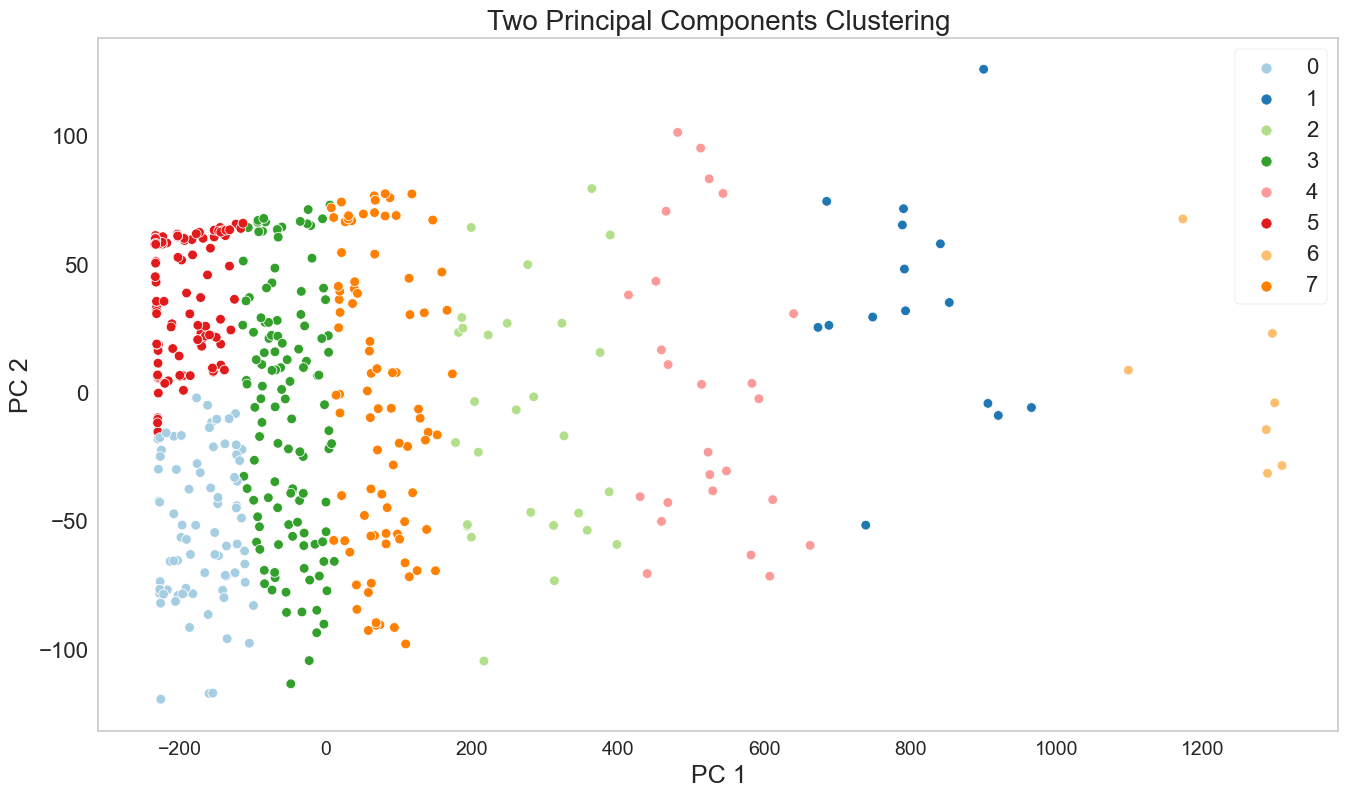

In [20]:
fig, ax=plt.subplots(figsize=(16, 9))

p_components=\
pd.DataFrame(pca.fit_transform(module_analysis))

p_components["Module Code"]=module_analysis.index 

p_components.set_index("Module Code", inplace=True)
p_components["Cluster"]=clusters

#Join it to the other features
#p_components

sns.scatterplot(data=p_components, x=0, y=1, hue="Cluster", palette=colours)

plt.grid(False)
#Set the options for the axes
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=14)
    
ax.legend(fontsize=16, frameon=True)
ax.set_xlabel("PC 1",fontsize=18)
ax.set_ylabel("PC 2",fontsize=18)
#Set the title for the bar chart for ease of understanding
ax.set_title("Two Principal Components Clustering", fontsize=20)

plt.show()

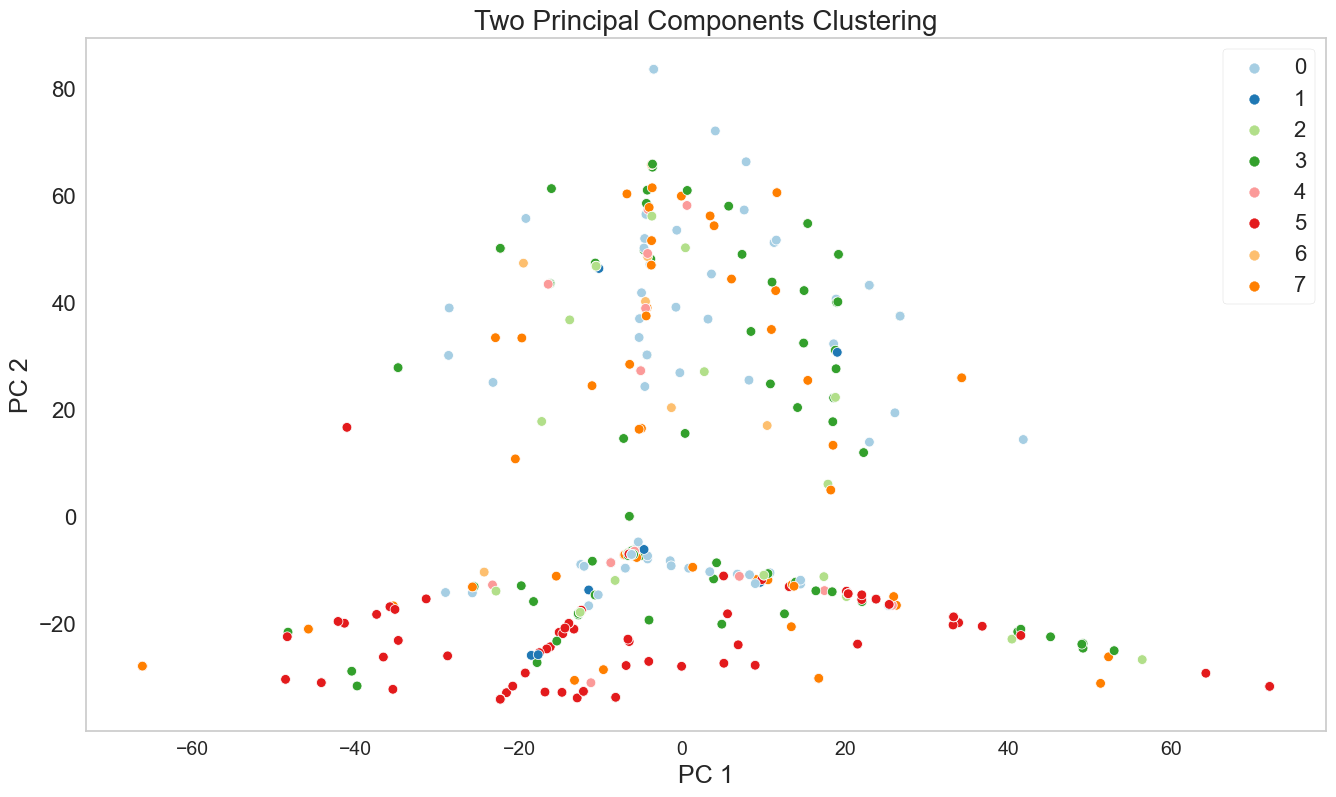

In [21]:
fig, ax=plt.subplots(figsize=(16, 9))

p_components=\
pd.DataFrame(pca.fit_transform(module_analysis[["Assignment", "Attendance", "Class Test",\
                                                "Continuous Assessment", "Essay", "Examination", "Fieldwork",\
"Group Project", "Journal", "Lab Report", "Multiple Choice Questionnaire", "Oral Examination", "Portfolio",\
"Practical Examination", "Presentation", "Project", "Seminar", "Studio Examination"]]))

p_components["Module Code"]=module_analysis.index 

p_components.set_index("Module Code", inplace=True)
p_components["Cluster"]=clusters

#Join it to the other features
#p_components

sns.scatterplot(data=p_components, x=0, y=1, hue="Cluster", palette=colours)

plt.grid(False)
#Set the options for the axes
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=14)
    
ax.legend(fontsize=16, frameon=True)
ax.set_xlabel("PC 1",fontsize=18)
ax.set_ylabel("PC 2",fontsize=18)
#Set the title for the bar chart for ease of understanding
ax.set_title("Two Principal Components Clustering", fontsize=20)

plt.show()

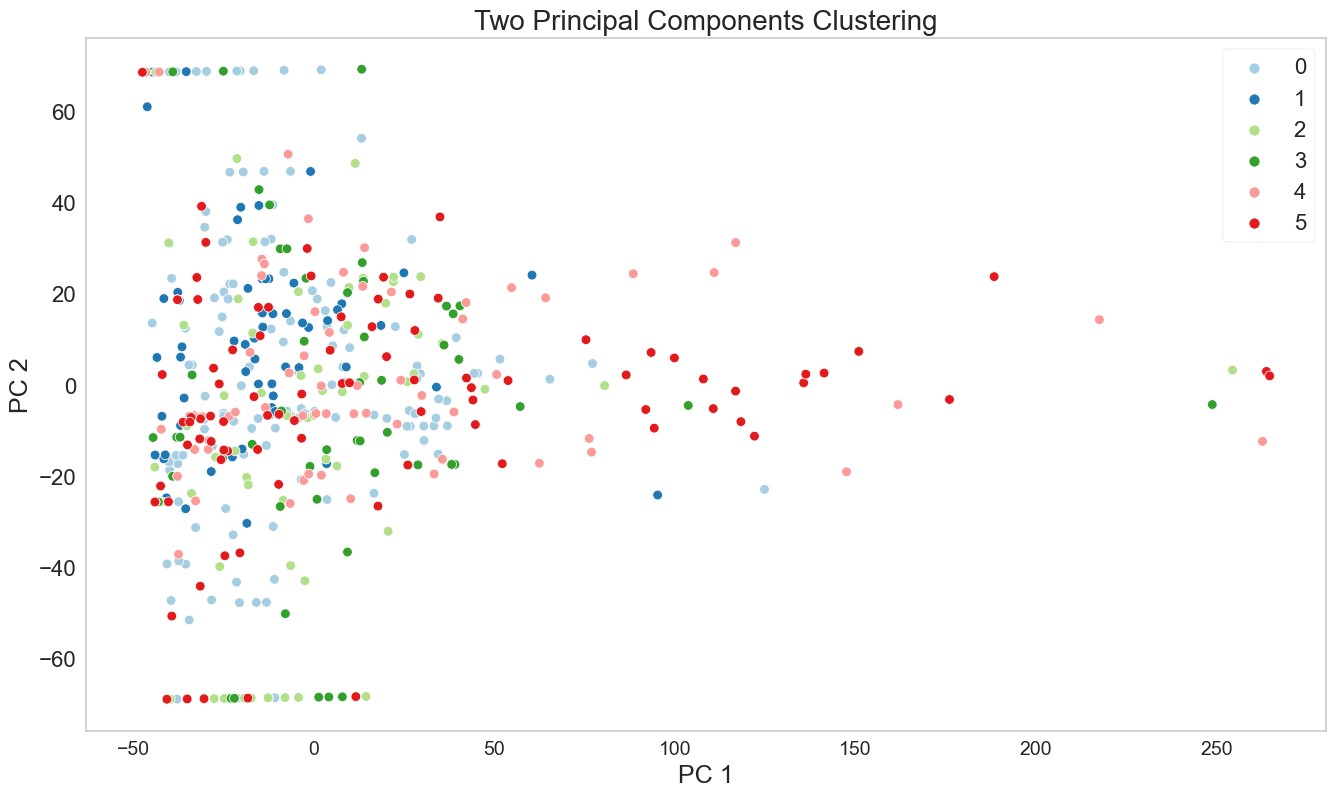

In [22]:
fig, ax=plt.subplots(figsize=(16, 9))

p_components=\
pd.DataFrame(pca.fit_transform(module_analysis[["Enrolled Students 22/23", "Assignment", "Attendance", "Class Test",\
                                                "Continuous Assessment", "Essay", "Examination", "Fieldwork",\
"Group Project", "Journal", "Lab Report", "Multiple Choice Questionnaire", "Oral Examination", "Portfolio",\
"Practical Examination", "Presentation", "Project", "Seminar", "Studio Examination"]]))

p_components["Module Code"]=module_analysis.index 

p_components.set_index("Module Code", inplace=True)
p_components["Cluster"]=clusters
p_components["School"]=module_analysis["School"]

#Join it to the other features
school_colours={0:"#a6cee3", 1:"#1f78b4", 2:"#b2df8a", 3:"#33a02c", 4:"#fb9a99", 5:"#e31a1c"}

sns.scatterplot(data=p_components, x=0, y=1, hue="School", palette=school_colours)

plt.grid(False)
#Set the options for the axes
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=14)
    
ax.legend(fontsize=16, frameon=True)
ax.set_xlabel("PC 1",fontsize=18)
ax.set_ylabel("PC 2",fontsize=18)
#Set the title for the bar chart for ease of understanding
ax.set_title("Two Principal Components Clustering", fontsize=20)

plt.show()

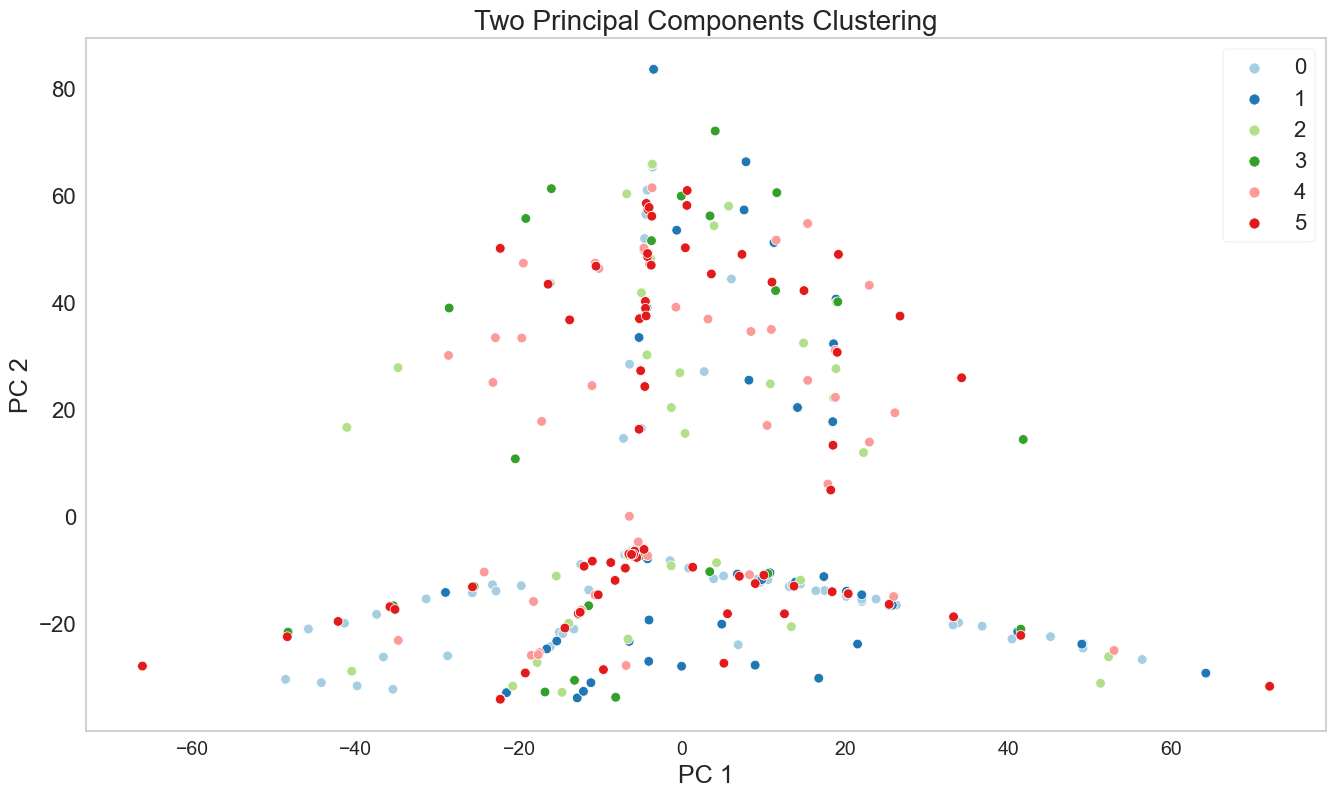

In [23]:
fig, ax=plt.subplots(figsize=(16, 9))

p_components=\
pd.DataFrame(pca.fit_transform(module_analysis[["Level", "Assignment", "Attendance", "Class Test",\
                                                "Continuous Assessment", "Essay", "Examination", "Fieldwork",\
"Group Project", "Journal", "Lab Report", "Multiple Choice Questionnaire", "Oral Examination", "Portfolio",\
"Practical Examination", "Presentation", "Project", "Seminar", "Studio Examination"]]))

p_components["Module Code"]=module_analysis.index 

p_components.set_index("Module Code", inplace=True)
p_components["Cluster"]=clusters
p_components["School"]=module_analysis["School"]

#Join it to the other features
school_colours={0:"#a6cee3", 1:"#1f78b4", 2:"#b2df8a", 3:"#33a02c", 4:"#fb9a99", 5:"#e31a1c"}

sns.scatterplot(data=p_components, x=0, y=1, hue="School", palette=school_colours)
plt.grid(False)
#Set the options for the axes
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=14)
    
ax.legend(fontsize=16, frameon=True)
ax.set_xlabel("PC 1",fontsize=18)
ax.set_ylabel("PC 2",fontsize=18)
#Set the title for the bar chart for ease of understanding
ax.set_title("Two Principal Components Clustering", fontsize=20)

plt.show()

Enrolled students, if omitted, changes the PCA graph to the shape of a pyramid.

In [24]:
def part_pie(centroids, fig, ax, cluster=None):
    #These are for selecting colours and exploded level for each pie segment
    colouring={0:"#a6cee3", 1:"#1f78b4", 2:"#b2df8a", 3:"#33a02c", 4:"#fb9a99", 5:"#e31a1c", 6:"#fdbf6f", 7:"#ff7f00"}
    colours=[]
    exploded=[]
    for c in centroids.index:
        colours.append(colouring[c])
        if int(cluster) == int(c):
            exploded.append(0.15)
        else:
            exploded.append(0)
        
    #Make the part of a whole pie chart
    ax.pie(centroids["Cluster Size"],\
           wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white', "alpha" : 0.9}, \
            labels=centroids.index, explode=exploded, \
           colors=colours, textprops={'fontsize':18})

    #Set the title of the pie chart for ease of understanding
    ax.set_title("Proportions of Different Clusters", fontsize=20)
    
    #if num_unique!=None:
    #    ax.set_xlabel("\n\nNumber of Modules in this Breakdown: %d" %(num_unique), fontsize=20)
    
    return fig, ax

In [25]:
def assessment_bar(centroids, fig, bx, cluster=None):
    #Just get the columns we want to graph
    centroids=centroids[["Assignment", "Attendance", "Class Test",\
                                                "Continuous Assessment", "Essay", "Examination", "Fieldwork",\
    "Group Project", "Journal", "Lab Report", "Multiple Choice Questionnaire", "Oral Examination", "Portfolio",\
    "Practical Examination", "Presentation", "Project", "Seminar", "Studio Examination"]]
    
    #These are for selecting colours for each bar in the bar chart
    colour_dict={"At home": "#1f78b4", "Blended": "#a6cee3", "In person":"#b2df8a"}
    colours=[]
    
    #Go through all the columns in the centroids, and set the colour, and make sure that they are float values
    for column in centroids.columns:
        colours.append(colour_dict[work_type[column]])
        centroids[column]=centroids[column].astype(float)
    
    plt.grid(False)
    
    
    
    #Make the assessment type average value bar chart
    bx.barh(centroids.columns, width=centroids.iloc[cluster], edgecolor="white", color=colours, alpha=0.9)
    
    #Set the options for the axes
    bx.set_xlim(0, 100)
    bx.tick_params(axis='y', labelsize=16)
    bx.tick_params(axis='x', labelsize=16)
    
    fmt = '%d%%' # Format you want the ticks, e.g. '40%'
    xticks = mtick.FormatStrFormatter(fmt)
    bx.xaxis.set_major_formatter(xticks)
    bx.set_xlabel("Average Percentage of Module Assessment",fontsize=18)
    #Set the title for the bar chart for ease of understanding
    bx.set_title("Average Assessment Worth for Cluster", fontsize=20)
    
    #Make the legend
    labels = list(colour_dict.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colour_dict[label]) for label in labels]
    bx.legend(handles, labels,fontsize=20)
    
    return fig, bx

In [26]:
def details(module_analysis, centroids, cluster):
    #Get the cluster we want details on
    centroid=centroids.iloc[cluster]
    w_cluster=module_analysis[module_analysis["Cluster"]==cluster]
    
    #Get the details we want
    print("There are %d modules in this cluster." %centroid["Cluster Size"])
    print("Schools: %s" % w_cluster["School"].value_counts())
    print("Levels: %s" % w_cluster["Level"].value_counts())
    print("Average Credits: %.2f" %(float(centroid["Credits"])))
    print("Average Amount of Students in a Module from this Cluster in 22/23: %d" %(float(centroid["Enrolled Students 22/23"])))

In [27]:
def cluster_graphs(module_analysis, cluster=None):
    #Data Manipulation
    #####################################################################
    #Make a dataframe of the centroids created in kmeans
    centroids=pd.DataFrame(kmeans.cluster_centers_)
    module_analysis["Cluster"]=kmeans.labels_

    #Make sure that the module analysis columns match those of the centroids
    centroids.columns=module_analysis.columns

    #And that all the columns are in either int or a decimal to two places format
    for column in centroids.columns:
        if column != "Cluster":
            centroids[column]=centroids[column].apply(lambda x: "%.2f" %x)

    #Get the size of each cluster
    centroids["Cluster Size"]=module_analysis["Cluster"].value_counts()

    ########################################################################
    #Graphs
    ########################################################################
    fig, (ax, bx)=plt.subplots(ncols=2, figsize=(16, 9))
    
    #The pie chart
    part_pie(centroids, fig, ax, cluster=cluster)
    
    #The horizontal bar chart
    assessment_bar(centroids, fig, bx, cluster=cluster)
    
    #The cluster details
    details(module_analysis, centroids, cluster)
    
    fig.suptitle("Module Cluster %d Analysis" %cluster, fontsize=24)
    fig.tight_layout()

There are 124 modules in this cluster.
Schools: School
0    42
2    25
3    16
4    16
5    14
1    11
Name: count, dtype: int64
Levels: Level
4    76
3    27
2    13
1     8
Name: count, dtype: int64
Average Credits: 7.30
Average Amount of Students in a Module from this Cluster in 22/23: 30


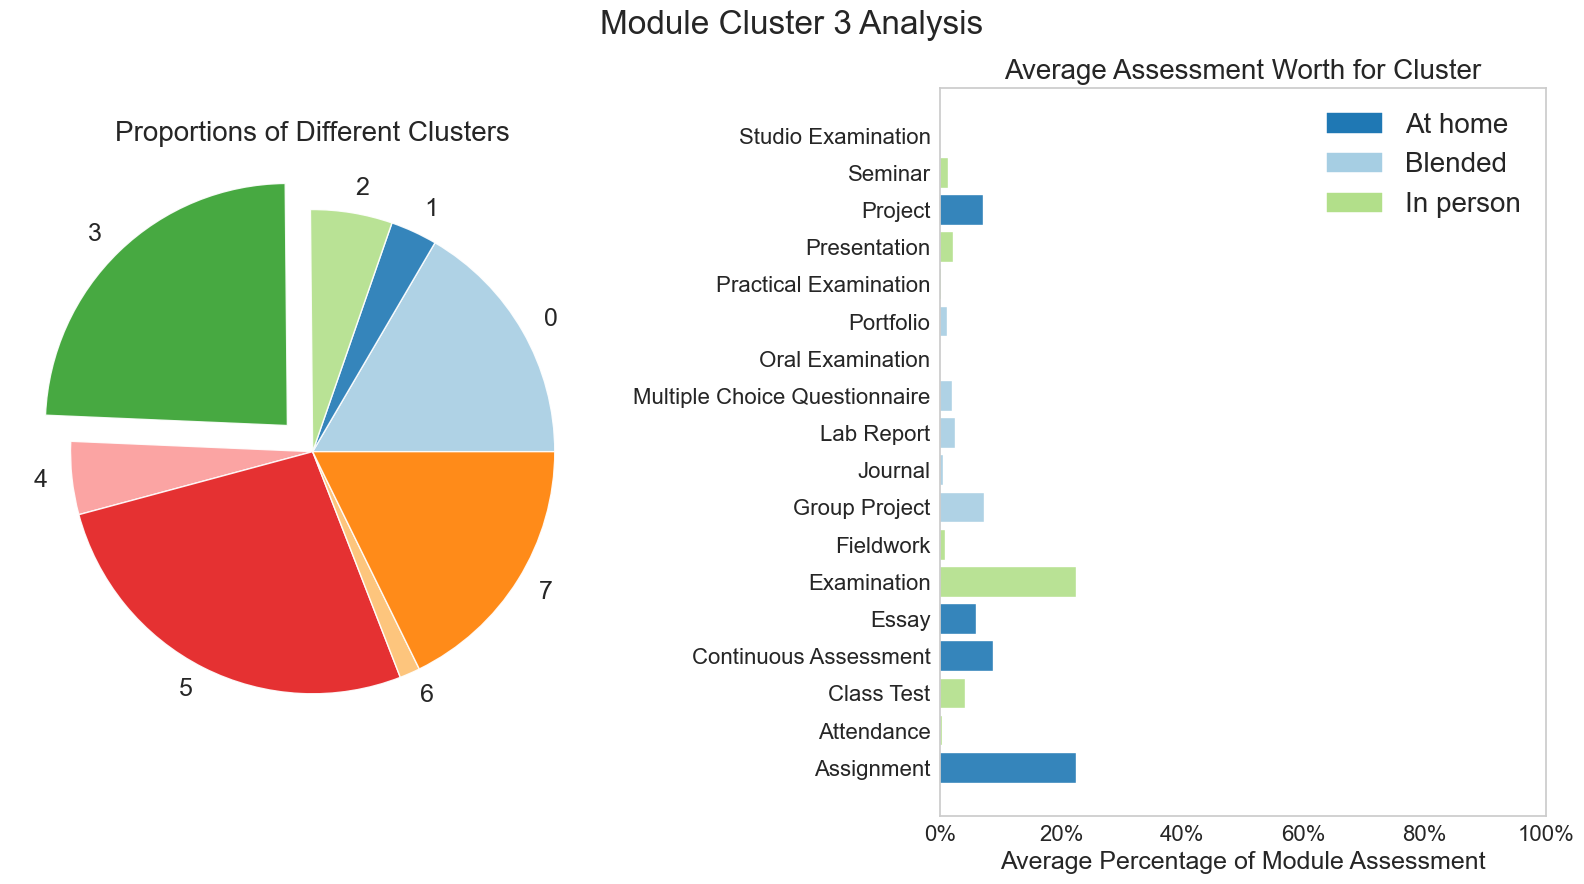

In [43]:
cluster_graphs(module_analysis, cluster=3)

In [29]:
centroids.iloc[1].array

<PandasArray>
[   '2.06',    '3.00',   '94.19',   '15.94',    '5.69',    '0.00',    '3.44',
    '0.62',    '0.00',    '6.88',    '6.25',    '3.12',    '0.00',    '2.75',
    '0.00',    '0.00',   '44.88',    '0.00',    '1.88',   '16.62',    '0.00',
    '0.00', '1027.81',   '18.44',   '22.94',   '50.75',      4.75,        16]
Length: 28, dtype: object

In [30]:
centroids.columns

Index(['School', 'Level', 'Enrolled Students 22/23', 'Credits', 'Assignment',
       'Attendance', 'Class Test', 'Continuous Assessment', 'Essay',
       'Examination', 'Fieldwork', 'Group Project', 'Journal', 'Lab Report',
       'Multiple Choice Questionnaire', 'Oral Examination', 'Portfolio',
       'Practical Examination', 'Presentation', 'Project', 'Seminar',
       'Studio Examination', 'Student Credits', 'In Person Percentage',
       'At Home Percentage', 'Blended Percentage', 'Cluster', 'Cluster Size'],
      dtype='object', name='Assessment Type')

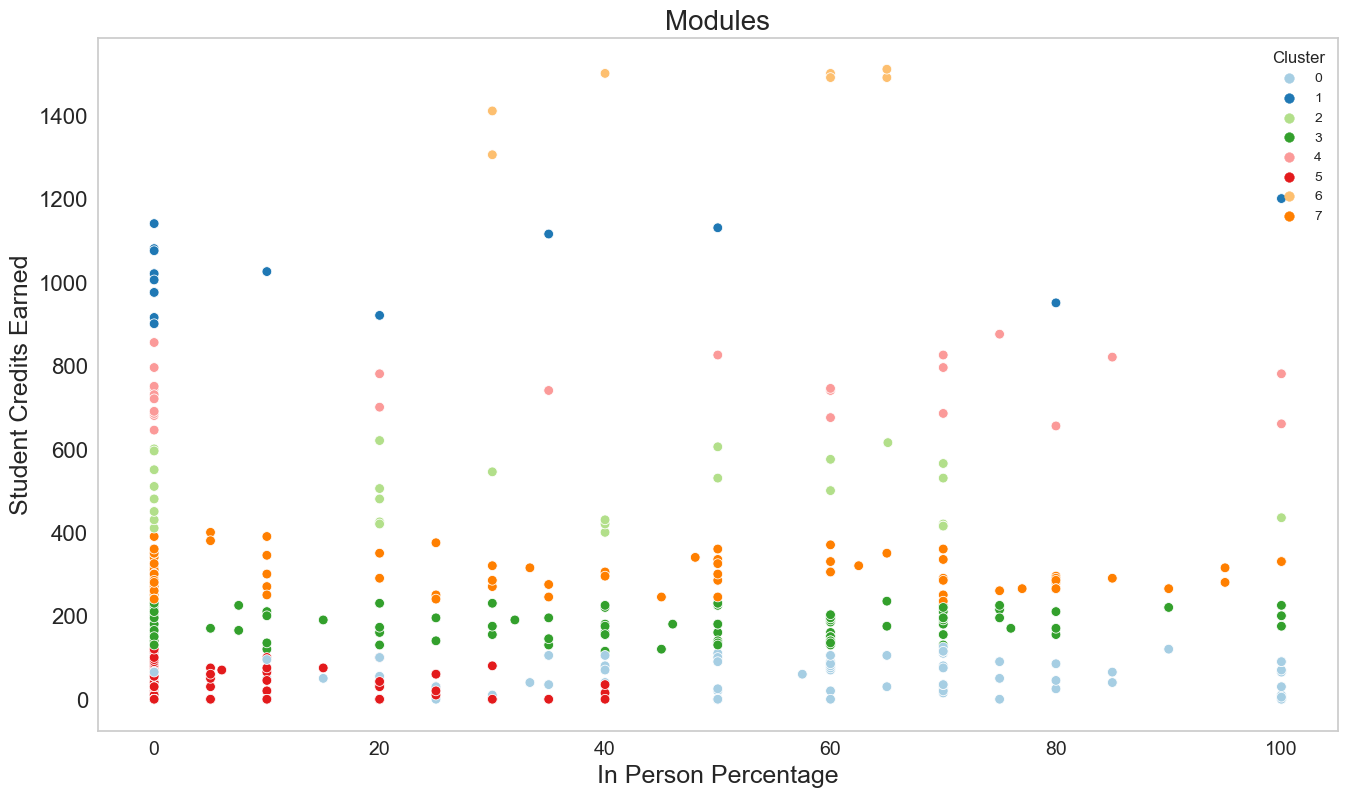

In [31]:
fig, ax=plt.subplots(figsize=(16, 9))

sns.scatterplot(data=module_analysis, x="In Person Percentage", y="Student Credits", hue="Cluster", palette=colours)
#sns.scatterplot(data=centroids, x=0, y=1, hue="Cluster", palette=colours, marker='*')

plt.grid(False)
#Set the options for the axes
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=14)
    
#ax.legend(fontsize=16, frameon=True)
ax.set_xlabel("In Person Percentage",fontsize=18)
ax.set_ylabel("Student Credits Earned",fontsize=18)
#Set the title for the bar chart for ease of understanding
ax.set_title("Modules", fontsize=20)

plt.show()

In [44]:
cluster_list=module_analysis[module_analysis["Level"]==1]

cluster_list

Assessment Type,School,Level,Enrolled Students 22/23,Credits,Assignment,Attendance,Class Test,Continuous Assessment,Essay,Examination,...,Practical Examination,Presentation,Project,Seminar,Studio Examination,Student Credits,In Person Percentage,At Home Percentage,Blended Percentage,Cluster
Module Code,,,,,,,,,,,,,,,,,,,,,
ARCT10010,0,1,72,15.0,0.000000,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0,0.0,1080.0,0.0,0.000000,100.0,1
ARCT10020,0,1,61,15.0,0.000000,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0,0.0,915.0,0.0,0.000000,100.0,1
ARCT10030,0,1,78,5.0,0.000000,0,0.0,0.0,0.0,0,...,0,0.0,50.0,0,0.0,390.0,0.0,50.000000,0.0,7
ARCT10040,0,1,61,5.0,0.000000,0,0.0,0.0,10.0,40,...,0,0.0,0.0,0,0.0,305.0,40.0,10.000000,50.0,7
ARCT10070,0,1,80,5.0,10.000000,0,0.0,0.0,30.0,40,...,0,0.0,0.0,0,0.0,400.0,40.0,40.000000,0.0,2
ARCT10090,0,1,61,5.0,13.333333,0,0.0,0.0,0.0,60,...,0,0.0,0.0,0,0.0,305.0,60.0,13.333333,0.0,7
ARCT10120,0,1,64,5.0,25.000000,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0,0.0,320.0,0.0,25.000000,50.0,7
ENVP10010,0,1,171,5.0,0.000000,0,0.0,30.0,0.0,0,...,0,0.0,0.0,0,0.0,855.0,0.0,30.000000,45.0,4
ENVP10030,0,1,46,5.0,37.500000,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0,0.0,230.0,0.0,37.500000,25.0,3


In [58]:
no_exam=module_analysis[module_analysis["Examination"]>=40]

no_exam

Assessment Type,School,Level,Enrolled Students 22/23,Credits,Assignment,Attendance,Class Test,Continuous Assessment,Essay,Examination,...,Practical Examination,Presentation,Project,Seminar,Studio Examination,Student Credits,In Person Percentage,At Home Percentage,Blended Percentage,Cluster
Module Code,,,,,,,,,,,,,,,,,,,,,
ARCT10040,0,1,61,5.0,0.000000,0,0.0,0.0,10.0,40,...,0,0.0,0.0,0,0.0,305.0,40.0,10.000000,50.0,7
ARCT10070,0,1,80,5.0,10.000000,0,0.0,0.0,30.0,40,...,0,0.0,0.0,0,0.0,400.0,40.0,40.000000,0.0,2
ARCT10090,0,1,61,5.0,13.333333,0,0.0,0.0,0.0,60,...,0,0.0,0.0,0,0.0,305.0,60.0,13.333333,0.0,7
ARCT20040,0,2,87,5.0,0.000000,0,0.0,0.0,0.0,100,...,0,0.0,0.0,0,0.0,435.0,100.0,0.000000,0.0,2
ARCT30030,0,3,84,5.0,0.000000,0,0.0,0.0,30.0,70,...,0,0.0,0.0,0,0.0,420.0,70.0,30.000000,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MEEN40800,5,4,67,5.0,0.000000,0,0.0,0.0,0.0,50,...,0,20.0,0.0,0,0.0,335.0,70.0,0.000000,30.0,7
MEEN41070,5,4,27,7.5,0.000000,0,0.0,0.0,0.0,60,...,0,0.0,0.0,0,0.0,202.5,60.0,0.000000,40.0,3
MEEN41090,5,4,65,5.0,50.000000,0,0.0,0.0,0.0,50,...,0,0.0,0.0,0,0.0,325.0,50.0,50.000000,0.0,7


In [47]:
no_exam=module_analysis[module_analysis["Project"]>=50]

no_exam

Assessment Type,School,Level,Enrolled Students 22/23,Credits,Assignment,Attendance,Class Test,Continuous Assessment,Essay,Examination,...,Practical Examination,Presentation,Project,Seminar,Studio Examination,Student Credits,In Person Percentage,At Home Percentage,Blended Percentage,Cluster
Module Code,,,,,,,,,,,,,,,,,,,,,
ARCT10030,0,1,78,5.0,0.0,0,0.0,0.0,0.0,0,...,0,0.0,50.0,0,0.0,390.0,0.0,50.0,0.0,7
ARCT20020,0,2,68,5.0,0.0,0,0.0,0.0,0.0,0,...,0,0.0,50.0,0,0.0,340.0,0.0,50.0,0.0,7
PLAN20020,0,2,34,5.0,0.0,0,0.0,40.0,0.0,0,...,0,0.0,60.0,0,0.0,170.0,0.0,100.0,0.0,3
ENVP30030,0,3,31,5.0,0.0,0,0.0,25.0,0.0,0,...,0,0.0,50.0,0,0.0,155.0,0.0,75.0,25.0,3
ARCT40010,0,4,51,5.0,0.0,0,0.0,0.0,0.0,0,...,0,0.0,100.0,0,0.0,255.0,0.0,100.0,0.0,7
ARCT41010,0,4,0,10.0,0.0,10,0.0,0.0,0.0,0,...,0,0.0,50.0,0,0.0,0.0,10.0,50.0,40.0,5
ENVP40040,0,4,15,10.0,0.0,0,0.0,50.0,0.0,0,...,0,0.0,50.0,0,0.0,150.0,0.0,100.0,0.0,3
LARC40450,0,4,1,30.0,0.0,0,0.0,0.0,0.0,0,...,0,25.0,50.0,0,0.0,30.0,25.0,50.0,25.0,5
LARC40510,0,4,1,15.0,0.0,0,0.0,0.0,0.0,0,...,0,40.0,60.0,0,0.0,15.0,40.0,60.0,0.0,5
